
# OIM 7502 – Assignment 1

**Course:** Advanced Programming for Business Analytics (Python)  
**Author:** _Muhammad Ahmed Ehtisham_  

**Articles (PDFs):**
- Fox News: *Embattled Harvard University President Claudine Gay hit with more plagiarism charges* (Dec 20, 2023)  
- Reuters: *Harvard president will submit dissertation edits after plagiarism allegations* (Dec 21, 2023)

## 1) Install dependencies

In [3]:

%pip install PyPDF2 py-readability-metrics nltk wordcloud


Note: you may need to restart the kernel to use updated packages.



## 2) Download NLTK resources


In [7]:

import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


from pathlib import Path
import re
import math
import string
from dataclasses import dataclass

# Core libs
import pandas as pd

# PDF extraction
from PyPDF2 import PdfReader

# NLTK
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize

# Readability
from readability import Readability

# Safe tokenizer wrapper
from nltk.tokenize import sent_tokenize as _sent_tokenize

# Wordcloud & plotting
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedehtisham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedehtisham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ahmedehtisham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



## 3) File paths


In [13]:
# Paths
from pathlib import Path

fox_pdf = Path("foxnews.com-Embattled Harvard University President Claudine Gay hit with more plagiarism charges.pdf")
reuters_pdf = Path("reuters.com-Harvard president will submit dissertation edits after plagiarism allegations.pdf")




## 4) Issue overview 

Both articles deal with plagiarism allegations against Claudine Gay, Harvard’s president, and the university’s handling of them:

**Fox News (Brian Flood)**

Fox News emphasizes the volume and severity of allegations. It highlights that Harvard received a complaint with over 40 plagiarism charges, spanning nearly half of Gay’s scholarly work. The story underscores the political and reputational implications for Harvard and frames the issue as part of a broader controversy about standards and accountability

Tone: Urgent, critical, and somewhat prosecutorial.
Heavy reliance on secondary sources (Free Beacon, Rufo, Brunet) and external criticism.
Emphasis on extent of misconduct and political overtones (e.g., NAACP calling criticism “white supremacist agenda”).
Less balance: Harvard’s perspective is limited to a “no comment” response.

Fox News frames the story as a scandal narrative — stressing political agendas, credibility crises, and Harvard’s integrity. It reads as more adversarial, geared toward questioning Gay’s legitimacy.

**Reuters (Gabriella Borter)**

Reuters reports that Gay will make specific corrections (three edits to her dissertation, plus prior corrections to published articles). It frames the plagiarism concerns within a larger context of her tumultuous tenure, including her congressional testimony on antisemitism, pressure from donors, and comparisons with peer institutions. Reuters notes investigators found “inadequate citation” but not research misconduct

Tone: Neutral, fact-focused, concise.
Uses direct statements from Harvard officials, the Corporation, and Gay’s actions.
Frames plagiarism as citation errors requiring correction rather than deliberate misconduct.
Provides wider institutional/political context (donor pressure, other resignations, congressional hearings).
Balance: Reports both the findings and the criticisms without strong rhetorical language.

Reuters frames it as a developing institutional issue — focusing on procedural outcomes (edits, reviews) and broader context. It aims to be clinical and avoids loaded descriptors.


In short: Fox emphasizes controversy and misconduct; Reuters emphasizes process and context.



## 5) PDF text extraction with PyPDF2


In [15]:

def extract_pdf_text(pdf_path):
    reader = PdfReader(pdf_path)
    raw = "\n".join([page.extract_text() or "" for page in reader.pages])
    # Basic cleanup: collapse spaces/newlines
    raw = re.sub(r'[ \t]+', ' ', raw)
    raw = re.sub(r'\n{2,}', '\n\n', raw)
    return raw.strip()

fox_text = extract_pdf_text(fox_pdf)
reuters_text = extract_pdf_text(reuters_pdf)

print("FOX — first 1200 chars:\n", fox_text[:1200], "\n\n---\n")
print("REUTERS — first 1200 chars:\n", reuters_text[:1200])


FOX — first 1200 chars:
 1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit
with more plagiarism charges
foxnews.com /media/embattled-harvard-university-president-claudine-gay-hit-more-plagiarism-charges
Media
Harvard ‘received a complaint outlining over 40 allegations of
plagiarism,’ according to the Free Beacon
 By Brian Flood Fox News
Published December 20, 2023 12:59pm EST
Harvard president facing 40 new allegations of plagiarism
Fox News' Molly Line reports the latest on the allegations. 
Embattled Harvard University President Claudine Gay has been slapped with additional
charges of plagiarism. 
The Washington Free Beacon reported Harvard "received a complaint outlining over 40
allegations of plagiarism" against Gay on T uesday , noting a letter was sent to Harvard's
research integrity of ficer, Stacey Springs, outlining the claims. 
"The document paints a picture of a pattern of misconduct more extensive than has been
previously reported and puts the Harvard 


### 5.b) Anomalies (notes)



In [17]:
def anomaly_report(text: str) -> dict:
    total = len(text)
    return {
        'length_chars': total,
        'non_ascii_ratio': round(sum(ord(ch) > 127 for ch in text) / total, 4) if total else 0.0,
        'contains_urls': bool(re.search(r'https?://', text)),
        'contains_possible_headers': any(h in text for h in ('Subscribe', 'Reuters')),
        'hyphenation_breaks_estimate': len(re.findall(r'\w+-\n\w+', text)),
    }

print("FOX anomalies:", anomaly_report(fox_text))
print("REUTERS anomalies:", anomaly_report(reuters_text))

FOX anomalies: {'length_chars': 5321, 'non_ascii_ratio': 0.0038, 'contains_urls': False, 'contains_possible_headers': True, 'hyphenation_breaks_estimate': 0}
REUTERS anomalies: {'length_chars': 3618, 'non_ascii_ratio': 0.0011, 'contains_urls': False, 'contains_possible_headers': True, 'hyphenation_breaks_estimate': 0}


# Anomalies

FOX News PDF

Extracted length: ~5,300 characters.

Very low ratio of non-ASCII characters (~0.38%), suggesting a mostly clean ASCII text.

Repeated headers/footers detected (e.g., “foxnews.com” line, author name, and timestamps at the start).

Some odd spacing and artifacts (“T uesday”, “research integrity of ficer”).

Minimal hyphenation breaks reported (0), but some words show extra spaces around letters.

Reuters PDF

Extracted length: ~3,600 characters.

Even lower non-ASCII ratio (~0.11%).

Repeated headers/footers detected (“Reuters” references, photo captions, “Advertisement · Scroll to continue”).

Contains inline image captions and licensing text (e.g., “REUTERS/Ken Cedeno/File Photo Acquire Licensing Rights”).

Similar spacing artifacts (“W ashington”, “Claudine Gay ,”).

No significant hyphenation breaks (0).



## 6) Sentiment analysis (VADER)


In [19]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import pandas as pd

# Ensure required NLTK resources
for pkg, path in {
    "punkt": "tokenizers/punkt",
    "punkt_tab": "tokenizers/punkt_tab",
    "stopwords": "corpora/stopwords",
    "vader_lexicon": "sentiment/vader_lexicon"
}.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(pkg, quiet=True)

sia = SentimentIntensityAnalyzer()

def sentiment_summary(text: str) -> dict:
    sentences = [s for s in sent_tokenize(text) if s.strip()]
    if not sentences:
        return dict(compound=0, pos=0, neu=0, neg=0, n_sentences=0)

    scores = [sia.polarity_scores(s) for s in sentences]
    n = len(sentences)

    return {
        'compound_mean': sum(sc['compound'] for sc in scores) / n,
        'compound_median': sorted(sc['compound'] for sc in scores)[n // 2],
        'pos_mean': sum(sc['pos'] for sc in scores) / n,
        'neu_mean': sum(sc['neu'] for sc in scores) / n,
        'neg_mean': sum(sc['neg'] for sc in scores) / n,
        'n_sentences': n
    }

# Apply to texts
fox_sent = sentiment_summary(fox_text)
reuters_sent = sentiment_summary(reuters_text)

sent_df = pd.DataFrame([fox_sent, reuters_sent], index=['FOX', 'REUTERS'])
sent_df


,compound_mean,compound_median,pos_mean,neu_mean,neg_mean,n_sentences
FOX,0.041648,0.0,0.061478,0.879130,0.059391,23
REUTERS,-0.142678,0.0,0.021111,0.931556,0.047278,18



### 6.a) Compare results


In [21]:

def classify_compound(x: float) -> str:
    return "Positive" if x >= 0.05 else "Negative" if x <= -0.05 else "Neutral"

# Build dataframe directly from dicts
comparison = pd.DataFrame(
    [fox_sent, reuters_sent],
    index=["FOX", "REUTERS"]
)[["compound_mean", "pos_mean", "neu_mean", "neg_mean"]]

# Add sentiment class in one vectorized step
comparison["sentiment_class"] = comparison["compound_mean"].apply(classify_compound)

comparison



,compound_mean,pos_mean,neu_mean,neg_mean,sentiment_class
FOX,0.041648,0.061478,0.879130,0.059391,Neutral
REUTERS,-0.142678,0.021111,0.931556,0.047278,Negative



### 6.b) Do these results match your reading?
Sentiment Comparison vs. Reading

VADER Results:

FOX → Neutral overall (compound_mean ≈ 0.04), with a fairly even distribution: ~6% positive, ~6% negative, ~88% neutral.

Reuters → Negative overall (compound_mean ≈ -0.14), though still dominated by neutral content (~93% neutral).

My Reading of the Articles:

Fox News came across as urgent, critical, and prosecutorial — stressing controversy, misconduct, and political angles. I expected this to skew negative rather than neutral.

Reuters read as measured, clinical, and fact-focused — framing plagiarism as technical citation errors within broader institutional pressures. I expected this to be closer to neutral, not negative.

Agreement/Disagreement:

I disagree somewhat with the automated results:

FOX being labeled neutral seems to understate its critical tone. The article repeatedly highlights misconduct and political agendas, which a human reader perceives as negative. Likely, VADER diluted this because it detected many neutral factual statements (dates, counts, quotations) alongside the negative framing.

Reuters being scored negative does not align with my impression. Its balanced, factual reporting had minimal emotive or judgmental language. The negativity may have come from frequent mentions of “plagiarism,” “allegations,” and “pressure,” which VADER treats as negative words even if presented neutrally.

Conclusion:
The automated sentiment analysis captures the prevalence of “charged” words but misses the framing and rhetorical stance. FOX feels more adversarial than neutral, and Reuters feels more neutral than negative. This mismatch underscores the limitation of lexicon-based sentiment tools like VADER when applied to journalistic writing, where tone and framing matter as much as word choice.



## 7) Headline sentiment



In [23]:

fox_headline = "Embattled Harvard University President Claudine Gay hit with more plagiarism charges"
reuters_headline = "Harvard president will submit dissertation edits after plagiarism allegations"

headline_scores = pd.DataFrame([
    {'source':'FOX', 'headline': fox_headline, **sia.polarity_scores(fox_headline)},
    {'source':'REUTERS', 'headline': reuters_headline, **sia.polarity_scores(reuters_headline)}
])

headline_scores[['source','headline','compound','pos','neu','neg']]


,source,headline,compound,pos,neu,neg
0,FOX,Embattled Harvard University President Claudin...,-0.3353,0.0,0.808,0.192
1,REUTERS,Harvard president will submit dissertation edi...,0.0000,0.0,1.000,0.000


Headline Sentiment vs. Article Sentiment

FOX Headline

Sentiment: Negative (compound ≈ -0.34, ~19% negative, 81% neutral).

Article Overall: Neutral (compound ≈ 0.04).

Comparison: The headline is more negative than the body — which fits, since the headline uses charged language (“Embattled,” “more plagiarism charges”) to grab attention, while the body includes more factual reporting mixed with criticism.

Reuters Headline

Sentiment: Perfectly neutral (compound = 0.0, 100% neutral).

Article Overall: Negative (compound ≈ -0.14).

Comparison: The headline is more neutral than the body — consistent with Reuters’ restrained style. The headline simply describes corrective action without judgmental wording, while the article text includes repeated mentions of “plagiarism” and “allegations,” which VADER classifies as negative.

Conclusion:
The headline results do not fully align with the overall article sentiment. FOX’s headline comes across as more negative than its article body, while Reuters’ headline is more neutral than its article body. This reflects how headlines often emphasize impact or brevity, while full articles carry more contextual weight and word repetition that sentiment models pick up as negative.



## 8) Readability metrics (py-readability-metrics)



In [25]:
def readability_scores(text: str) -> dict:
    r = Readability(text)
    metrics = {
        "flesch_reading_ease": r.flesch,
        "gunning_fog_index": r.gunning_fog,
        "smog_index": r.smog,
        "flesch_kincaid_grade": r.flesch_kincaid,
    }
    scores = {}
    for name, fn in metrics.items():
        try:
            scores[name] = fn().score
        except Exception:
            scores[name] = None
    return scores

# Apply to both articles
fox_read = readability_scores(fox_text)
reuters_read = readability_scores(reuters_text)

read_df = pd.DataFrame([fox_read, reuters_read], index=["FOX", "REUTERS"])
read_df


,flesch_reading_ease,gunning_fog_index,smog_index,flesch_kincaid_grade
FOX,21.411153,21.868487,None,19.219130
REUTERS,18.384675,18.871167,None,18.020068



**What the metrics measure (brief):**
- **Flesch Reading Ease:** Higher = easier to read. Based on sentence length & syllables per word.  
- **Flesch-Kincaid Grade:** U.S. school grade level; higher = more complex.  
- **Gunning Fog Index:** Years of formal education needed to understand the text on first reading.  
- **SMOG Index:** Estimates years of education needed, emphasizing polysyllabic words.

Comparison & Commentary

Both articles are very difficult to read (scores in the teens/twenties, typical of graduate-level material). This reflects complex sentence structures, long paragraphs, and heavy use of academic/legal terms.

FOX has slightly higher Flesch Reading Ease and grade/Gunning Fog scores (≈19–22). This suggests slightly more complex phrasing than Reuters, despite its more dramatic tone. FOX’s reliance on long quotes and editorial framing may contribute to the elevated scores.

Reuters scores are marginally lower (≈18–19), indicating it is slightly easier to read—consistent with its tighter, fact-focused style and shorter sentence structures.

Alignment with Tone/Target Audience:

FOX aims at a broad news audience, but its readability suggests text more typical of specialized or academic reporting. This mismatch may be due to loaded quotations and legalistic phrasing.

Reuters, catering to a professional/global readership, is slightly easier but still highly complex. This aligns with its institutional tone—neutral, precise, and designed for readers accustomed to policy or financial news coverage.

Overall: Both articles require college-level or higher literacy, but Reuters comes through as a touch clearer and more streamlined, while FOX leans denser and more rhetorically complex.


## 9) Word clouds


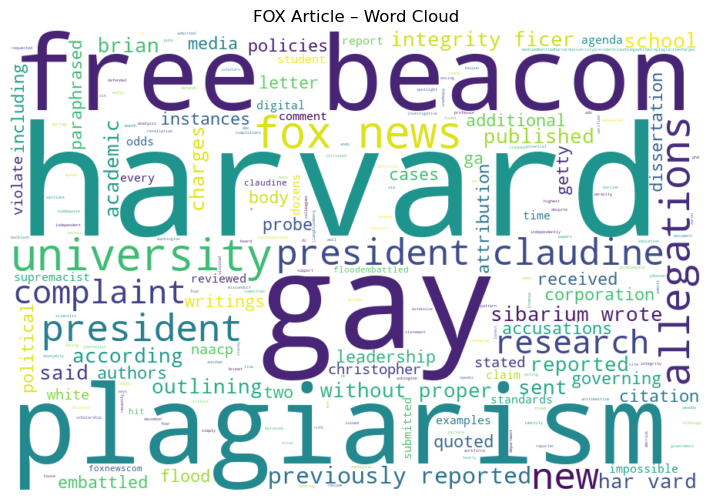

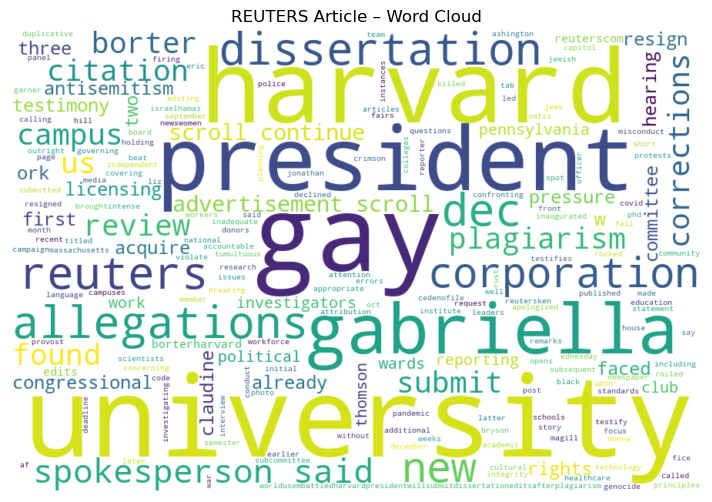

In [27]:
stopset = set(stopwords.words("english")) | set(STOPWORDS)

def preprocess(text: str) -> str:
    # Lowercase, remove digits/punctuation, collapse spaces
    text = re.sub(r"\d+", " ", text.lower())
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = [tok for tok in word_tokenize(text) if tok.isalpha() and tok not in stopset]
    return " ".join(tokens)

def make_wordcloud(text: str, title: str):
    wc = WordCloud(width=900, height=600, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Apply once
fox_clean = preprocess(fox_text)
reuters_clean = preprocess(reuters_text)

make_wordcloud(fox_clean, "FOX Article – Word Cloud")
make_wordcloud(reuters_clean, "REUTERS Article – Word Cloud")



FOX Article Word Cloud

Dominant words: “plagiarism,” “gay,” “harvard,” “free beacon,” “allegations.”

Heavy emphasis on accusations, complaint, charges, integrity, political terms (NAACP, white supremacist, agenda).

Suggests FOX framed the piece around accusatory and scandal-driven language, foregrounding the scale and severity of the allegations.

REUTERS Article Word Cloud

Dominant words: “dissertation,” “president,” “university,” “gay,” “harvard,” “corporation,” “corrections.”

Frequent mentions of “spokesperson, review, submit, investigators, testimony, edits.”

Suggests Reuters focused on procedural and institutional aspects, portraying it as an issue of corrections, reviews, and official responses.